# Repeated Measures ANOVA

This notebook uses the file `meditation.csv` file.


In [1]:
import numpy.random as npr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pingouin as pg


In a previous notebook we looked at how to calcluate ANOVA when each participant is assigned to one group (one-way ANOVA) or combination of groups (N-way ANOVA).

When your experimental design has measurements from the same people in multiple conditions you are in the realm of repeated measures ANOVA.

For example, a between participants ANOVA might measure the effect of performing some task under three different levels of distraction (low, medium, high), with different people assigned to each of the three distraction groups.

If each person performed the task under each of the three different levels of distraction we would want to run a repeated measures ANOVA. 

The primary reason for the difference has to do with how the variance is accounted for or partitioned in the different settings and you can find abundant discussion of the details in your stats notes or in any number of online sources. In this notebook we'll focus on the mechanics of running the analysis in Python.

## A mixed design repeated measures dataset

_(Thanks to Raphael Vallat for the example)_

As an example, we will ask whether meditation can improve school performance in primary school students.

If we want to study that, one way would be to split a group of students into a control group and a meditation group, i.e. a certain number of students will be instructed to meditate for 20 minutes a day every day of the week, while the remaining students will be instructed not to change anything to their usual daily routine. This factor is our between-group factor.

Now, we want to examine how meditation significantly improves or worsens the performances over time, starting from the beginning of the school year (August) to the end of the school year. To study that, we are going to assess their school performances at three time points during the year: 

August (or time = 0 months)

January (time = +6months)

June (time = +12 months)


Our data will have: the test scores (dependent variable), time of year (three levels; within participant), and meditation or control group (two levels; between participants). This is a "mixed design" because we have a mix of within and between participants.

A simulated dataset with this structure is saved in meditation.csv

In [2]:
df = pd.read_csv('../../../data/stats_data/meditation.csv')
df.head()

,Unnamed: 0,Scores,Time,Group,Subject
0,0,5.971435,August,Control,0
1,1,4.309024,August,Control,1
2,2,6.932707,August,Control,2
3,3,5.187348,August,Control,3
4,4,4.779411,August,Control,4


In [4]:
# data from one person
df[df['Subject']==1]

,Unnamed: 0,Scores,Time,Group,Subject
1,1,4.309024,August,Control,1
31,31,5.837438,January,Control,1
61,61,5.429655,June,Control,1


We can check out the overall pattern of results visually using any number of seaborn plot types. Here we use .pointplot()

<AxesSubplot:xlabel='Time', ylabel='Scores'>

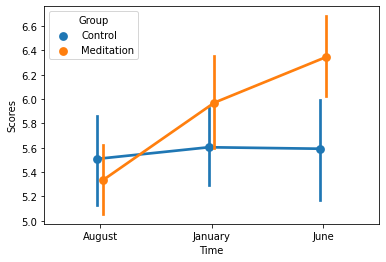

In [6]:
import seaborn as sns

sns.pointplot(data=df, x='Time', y='Scores', hue='Group', dodge=True)


Or take a look at the mean and std for each group combination using groupby:

In [7]:
df.groupby(['Time', 'Group'])['Scores'].agg(['mean', 'std']).round(2)


mean   std
Time    Group                 
August  Control     5.51  1.03
        Meditation  5.33  0.81
January Control     5.60  0.90
        Meditation  5.97  1.07
June    Control     5.59  1.18
        Meditation  6.35  0.93

# One-way Repeated measures ANOVA

First, let's just run a repeated measures ANOVA on one of our factors: Time. Each person was tested at three timepoints so looking at that factor gives us a pure within participant or repeated measures design.

In [9]:
df.head()

,Unnamed: 0,Scores,Time,Group,Subject
0,0,5.971435,August,Control,0
1,1,4.309024,August,Control,1
2,2,6.932707,August,Control,2
3,3,5.187348,August,Control,3
4,4,4.779411,August,Control,4


In [11]:
# use pinguoin for easy access to repeated measures anova:

# data is where the data live, dv is the outcome variable, 
# within is the predictor variable or IV, and subject is the column that links the 
# different measurements together
rm_results = pg.rm_anova(data=df, dv='Scores', within='Time', subject='Subject')
rm_results

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,Time,2,118,4.743616,0.010435,0.074417,0.997828


In [12]:
df1 = rm_results['ddof1'][0]
df2 = rm_results['ddof2'][0]
F = rm_results['F'][0]
p_val = rm_results['p-unc'][0]

print(f'F({df1}, {df2}) = {F}, p = {p_val}')

F(2, 118) = 4.7436160996362124, p = 0.010435267177615552


Using an ANOVA to test the effect of meditation (or none) on scores over time will require the use of mixed design ANOVA that enables us to account for both the between groups factor (meditation vs control) and the within person, or repeated measures, factor of time.

In [13]:
df.head()

,Unnamed: 0,Scores,Time,Group,Subject
0,0,5.971435,August,Control,0
1,1,4.309024,August,Control,1
2,2,6.932707,August,Control,2
3,3,5.187348,August,Control,3
4,4,4.779411,August,Control,4


To specify such a model in pingouin we need to define the dependent variable, the within subject factor, the between subject factor, and the id that links across repeated measures. In our data this is the 'Subject' column and this is what is used to match the scores over time within person.

In [14]:
aov = pg.mixed_anova(dv='Scores', 
                     within='Time', 
                     between='Group', 
                     subject='Subject', data=df)


Check out the results:

In [15]:
aov

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,Group,4.464979,1,58,4.464979,4.131122,0.046689,0.066490,NaN
1,Time,9.358520,2,116,4.679260,4.940789,0.008725,0.078499,0.997828
2,Interaction,6.539283,2,116,3.269641,3.452385,0.034960,0.056180,NaN


The results indicate a significant main effect of Group and Time as well as ain interaction, but not which pairs of measurements differ from each other. Pingouin also provides a nice way to get all the pairwise tests using `pg.pairwise_ttests()`

In [16]:
posthocs = pg.pairwise_ttests(dv='Scores', 
                              within='Time', 
                              between='Group',
                              subject='Subject', 
                              data=df)
posthocs

,Contrast,Time,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,Time,-,August,January,True,True,-2.002391,59.0,two-sided,0.049846,0.908,-0.378614
1,Time,-,August,June,True,True,-2.985041,59.0,two-sided,0.004122,7.594,-0.530177
2,Time,-,January,June,True,True,-1.023620,59.0,two-sided,0.310194,0.232,-0.169520
3,Group,-,Control,Meditation,False,True,-2.032516,58.0,two-sided,0.046689,1.447,-0.517978
4,Time * Group,August,Control,Meditation,False,True,0.733477,58.0,two-sided,0.466222,0.329,0.186923
5,Time * Group,January,Control,Meditation,False,True,-1.433725,58.0,two-sided,0.157020,0.619,-0.365379
6,Time * Group,June,Control,Meditation,False,True,-2.744291,58.0,two-sided,0.008058,5.593,-0.699371


Of course, that's a lot of pairwise tests to run, so if we want to use a corrected p value we can add in the padju= argument to the pairwise_ttests() function.

In [17]:
pg.pairwise_ttests(dv='Scores', 
                   within='Time', 
                   between='Group', 
                   subject='Subject',
                   data=df, 
                   padjust='bonf')

,Contrast,Time,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Time,-,August,January,True,True,-2.002391,59.0,two-sided,0.049846,0.149537,bonf,0.908,-0.378614
1,Time,-,August,June,True,True,-2.985041,59.0,two-sided,0.004122,0.012366,bonf,7.594,-0.530177
2,Time,-,January,June,True,True,-1.023620,59.0,two-sided,0.310194,0.930581,bonf,0.232,-0.169520
3,Group,-,Control,Meditation,False,True,-2.032516,58.0,two-sided,0.046689,NaN,NaN,1.447,-0.517978
4,Time * Group,August,Control,Meditation,False,True,0.733477,58.0,two-sided,0.466222,1.000000,bonf,0.329,0.186923
5,Time * Group,January,Control,Meditation,False,True,-1.433725,58.0,two-sided,0.157020,0.471060,bonf,0.619,-0.365379
6,Time * Group,June,Control,Meditation,False,True,-2.744291,58.0,two-sided,0.008058,0.024173,bonf,5.593,-0.699371


You can check the documentation for other p value adjustment methods:

'none': no correction

'bonf': one-step Bonferroni correction

'sidak': one-step Sidak correction

'holm': step-down method using Bonferroni adjustments

'fdr_bh': Benjamini/Hochberg FDR correction

'fdr_by': Benjamini/Yekutieli FDR correction



## Running rm ANOVA using statsmodels

If you prefer to run your repeated measures ANOVA using statsmodels library, you can use the AnovaRM function. The code below should make clear how we use it.

In [18]:
from statsmodels.stats.anova import AnovaRM

armfit = AnovaRM(data=df, 
                 depvar='Scores', 
                 subject='Subject', 
                 within=['Time']).fit()
armfit.summary()

,F Value,Num DF,Den DF,Pr > F
Time,4.7436,2.0000,118.0000,0.0104
